<a href="https://colab.research.google.com/github/ronitray95/DisasterManagement_ForestFire/blob/main/FF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules

In [ ]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.svm import LinearSVC

from sklearn import metrics,neural_network,linear_model,preprocessing,svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.interpolate import griddata
import scipy.cluster.hierarchy as sch
from scipy import spatial
import time
import math
import copy
import gdown
from string import ascii_uppercase

from sklearn.model_selection import train_test_split,GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score, mean_squared_error, r2_score
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz 
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,BaggingClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,SVR

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

## Load and read data

In [ ]:
gdown.download('https://docs.google.com/uc?export=download&id=1F56e5r6cI3hBfcyvz3YFw4Y03eAEdcAe','data.csv',quiet=True)

'data.csv'

In [ ]:
dfAll = pd.read_csv("data.csv")
dfAll.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [ ]:
dfAll.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [ ]:
from calendar import month_abbr,day_abbr

lower_ma = [m.lower() for m in month_abbr]

dfAll['month'] = dfAll['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

lower_ma = [m.lower() for m in day_abbr]

dfAll['day'] = dfAll['day'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

In [ ]:
# remove area=0
df = dfAll[dfAll.area != 0.0]
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,9,9,7,1,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
139,1,4,9,1,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
140,2,5,9,0,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
141,1,2,8,2,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
142,8,6,8,4,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,5,4,8,4,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17
510,6,5,8,4,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43
512,4,3,8,6,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,8,6,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29


In [ ]:
df.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,4.807407,4.366667,7.759259,3.174074,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,24.600185
std,2.383326,1.170740,2.115048,2.070162,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,86.501635
min,1.000000,2.000000,2.000000,0.000000,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.090000
25%,3.000000,4.000000,8.000000,1.000000,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,2.140000
50%,5.000000,4.000000,8.000000,3.000000,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,6.370000
75%,7.000000,5.000000,9.000000,5.000000,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,15.422500
max,9.000000,9.000000,12.000000,6.000000,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,1090.840000


# Visualization

## Forest fire Count

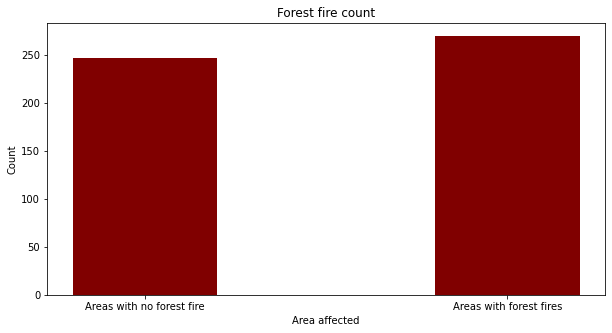

In [ ]:
# Area of fire
data = {'Areas with no forest fire':dfAll.shape[0]-df.shape[0], 'Areas with forest fires':df.shape[0]}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Area affected")
plt.ylabel("Count")
plt.title("Forest fire count")
plt.show()

## Heat Map

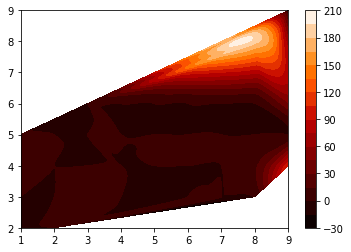

In [ ]:
my_data = np.array(dfAll)

Z_dat=my_data[1:517,12]
X_dat=my_data[1:517,0]
Y_dat=my_data[1:517,1]

X, Y, Z, = np.array([]), np.array([]), np.array([])
for i in range(len(X_dat)):
    X = np.append(X,X_dat[i])
    Y = np.append(Y,Y_dat[i])
    Z = np.append(Z,Z_dat[i])
zmin = 1
zmax = 9
xi = np.linspace(X.min(),X.max(),1000)
yi = np.linspace(Y.min(),Y.max(),1000)
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')
CS = plt.contourf(xi, yi, zi, 15, cmap=plt.cm.gist_heat)
plt.colorbar()  
plt.show()

## Coordinates of area affected

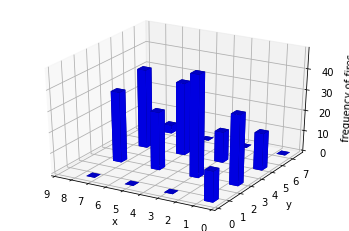

In [ ]:
intensity=dfAll.area
X=dfAll.X
Y=dfAll.Y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x=X.iloc[intensity.to_numpy().nonzero()[0]]
y=Y.iloc[intensity.to_numpy().nonzero()[0]]
#chose fewer bins to make it look less crowded.
hist, xedges, yedges = np.histogram2d(x,y,bins=4,range=[[0, 9], [0,9]])
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
#plt.ylim(9,0)
plt.xlim(9,0)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("frequency of fires")
plt.show()

In [ ]:
label=dfAll['area']
dfAll.drop(['area'],inplace=True,axis=1)
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    Int8   
 3   day     517 non-null    Int8   
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: Int8(2), float64(7), int64(3)
memory usage: 42.5 KB


In [ ]:
features_bin = np.where(label > 0.0,1,0) #1=area >0

X=np.array(dfAll)
Y=np.array(features_bin)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=142) #75% and 25%
features =list(dfAll)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
clf.fit(X, Y)
for feature in zip(features, clf.feature_importances_):
    print(feature)

('X', 0.09414696151460648)
('Y', 0.06290151979913455)
('month', 0.03663828483321526)
('day', 0.047987185581501224)
('FFMC', 0.09109988324943417)
('DMC', 0.10807595978810701)
('DC', 0.1068877872360178)
('ISI', 0.08500398946423714)
('temp', 0.1429093137544976)
('RH', 0.12543653374944755)
('wind', 0.09423108873415159)
('rain', 0.004681492295649522)


Here we can see that, out of all the features, Temperature contributes the most to a large forest fire and rain contributes the least. Hence, we can remove rain from our list of features.

In [ ]:
dfAll.drop(['rain'],inplace=True,axis=1)
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    Int8   
 3   day     517 non-null    Int8   
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
dtypes: Int8(2), float64(6), int64(3)
memory usage: 38.5 KB


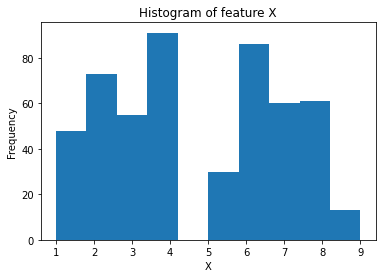

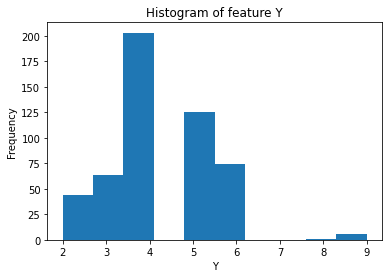

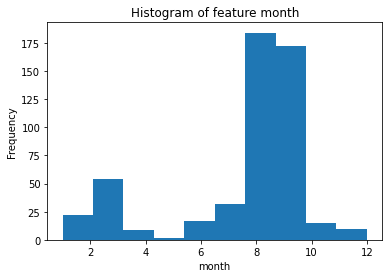

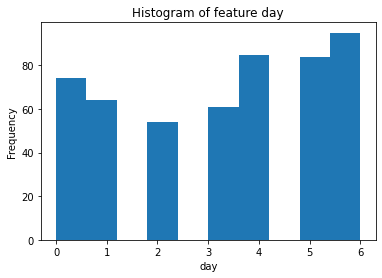

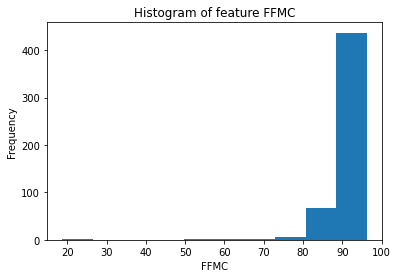

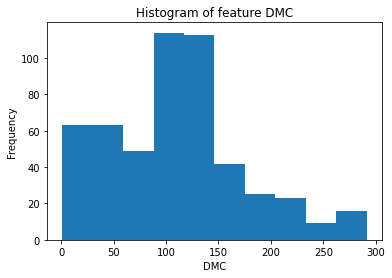

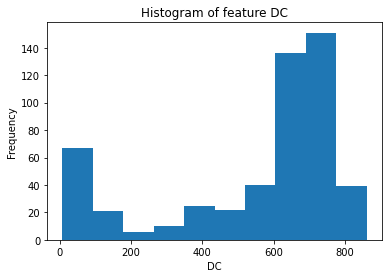

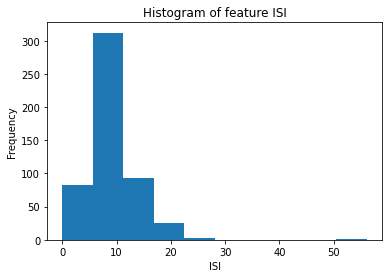

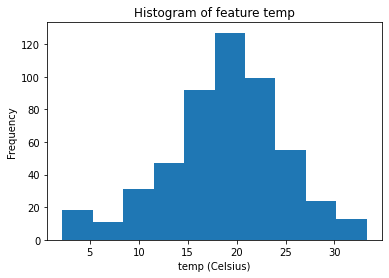

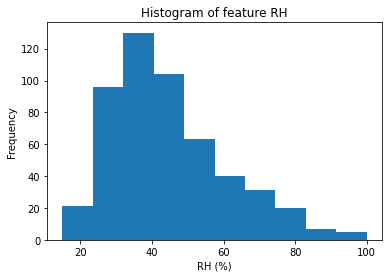

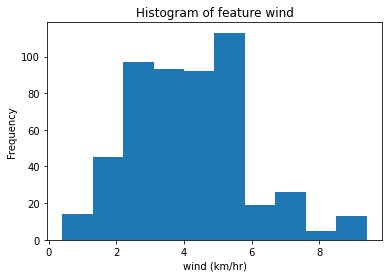

IndexError: ignored

In [ ]:
units =['co-ordinate','co-ordinate','none','none','ffmc','dmc','dc','si','Celsius','%','km/hr','mm/m2','']
for i in range(12):
    feature_name = dfAll.columns[i] 

    # Plotting Histogram of feature feature_name for part b
    plt.hist(dfAll.iloc[:, i])
    plt.ylabel('Frequency')
    plt.xlabel(feature_name+ (' (' + units[i]+')' if i>7 else ''))
    plt.title('Histogram of feature ' + feature_name)
    plt.show()

    # Plotting Scatter plot of feature feature_name and log(burned area + 1)
    # plt.scatter(dfAll.iloc[:, i], np.log(dfAll.iloc[:, 12] + 1))
    # plt.ylabel('log(burned area + 1)')
    # plt.xlabel(feature_name)
    # plt.title('Scatter plot of log(burned area +1) vs ' + feature_name)
    # plt.show()


# Plotting histogram of output variable for part c
plt.hist(dfAll.iloc[:, 12])
plt.ylabel('Frequency')
plt.xlabel('area (hectares)')
plt.title('Histogram of output variable area')
plt.show()

plt.hist(np.log(dfAll.iloc[:, 12] + 1))
plt.ylabel('Frequency')
plt.xlabel('log(area) + 1')
plt.title('Histogram of logarithm of output variable area + 1')
plt.show()

# Classification

## SVM

In [ ]:
X=np.array(dfAll)
Y=np.array(features_bin)
X=X[:,[8,9]]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25) #75% and 25%

In [ ]:
clf = svm.SVC(kernel='rbf',gamma=0.7) 

#Train the model using the training sets
clf.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy of SVM model--> {:.2f}".format(accuracy_score(Y_test, y_pred)))

Accuracy of SVM model--> 0.50


In [ ]:

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = (x_max /( x_min+1))/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))
plt.subplot(1, 1, 1)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.show()

In [ ]:
clf = svm.SVC(kernel='linear') 

#Train the model using the training sets
clf.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy of SVM model--> {:.2f}".format(accuracy_score(Y_test, y_pred)))

Accuracy of SVM model--> 0.53


## KNN

In [ ]:
features_bin = np.where(label > 0.0,1,0) #1=area >0

X=np.array(dfAll)
Y=np.array(features_bin)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=142) #75% and 25%
features =list(dfAll)

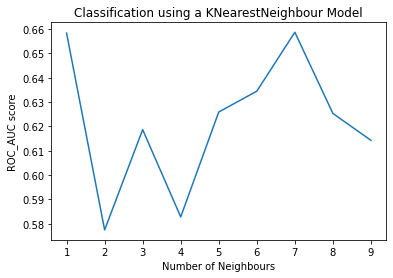

In [ ]:
K = []
roc = []


for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    K.append(k)
    roc.append(roc_auc_score(Y_test, Y_pred))

plt.plot(K,roc)
plt.title('Classification using a KNearestNeighbour Model')
plt.xlabel('Number of Neighbours')
plt.ylabel('ROC_AUC score')
plt.show()

In [ ]:
ind = roc.index(max(roc)) 
print("Maximum ROC of KNN is for k = {}".format(K[ind]))

Maximum ROC of KNN is for k = 7


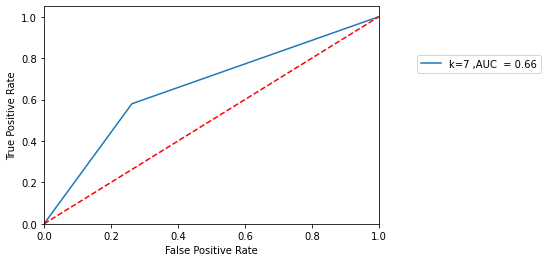

In [ ]:
auc_roc=[]
fp=[]
tp=[]
k=7


  
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, y_pred)
fp.append(fpr)
tp.append(tpr)
roc_auc = auc(fpr, tpr)
auc_roc.append(roc_auc)

plt.figure()

#for i in range(len(auc_roc)):
plt.plot(fp[i], tp[i], label = 'k={} ,AUC  = {:.2f}'.format(k,auc_roc[i]))
    
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor =(1.5,0.8), ncol = 3)
plt.show()

### for k = 7 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, Y_train)
Y_predicted = knn.predict(X_test)

print("Accuracy of KNN model--> {:.2f}".format(accuracy_score(Y_test, Y_predicted)))

Accuracy of KNN model--> 0.65


## Decision Tree 

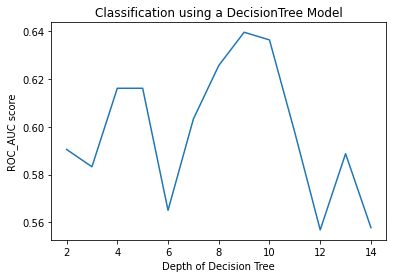

In [ ]:
nodes = []
roc_dt = []

for node in range(2, 15):
    dt = DecisionTreeClassifier(max_depth=node, random_state=1)
    dt.fit(X_train, Y_train)
    Y_pred = dt.predict(X_test)
    nodes.append(node)
    roc_dt.append(roc_auc_score(Y_test, Y_pred))

plt.plot(nodes,roc_dt)
plt.title('Classification using a DecisionTree Model')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('ROC_AUC score')
plt.show()

In [ ]:
ind = roc_dt.index(max(roc_dt)) 
print("Maximum ROC of Descision Tree is for Depth = {}".format(nodes[ind]))

Maximum ROC of Descision Tree is for Depth = 9


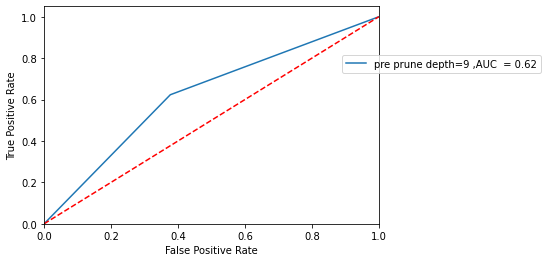

In [ ]:
auc_roc1=[]
fp1=[]
tp1=[]
depth=9


dt = DecisionTreeClassifier(max_depth=depth, random_state=1)
dt.fit(X_train, Y_train)
y_pred = dt.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, y_pred)
fp1.append(fpr)
tp1.append(tpr)
roc_auc = auc(fpr, tpr)
auc_roc1.append(roc_auc)

plt.figure()

for i in range(len(auc_roc1)):
    plt.plot(fp1[i], tp1[i], label = 'pre prune depth={} ,AUC  = {:.2f}'.format(depth,auc_roc1[i]))
    
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor =(1.5,0.8), ncol = 3)
plt.show()


### for depth = 9

In [ ]:

dt = DecisionTreeClassifier(max_depth=9, random_state=1)
dt.fit(X_train, Y_train)
Y_pred_dt = dt.predict(X_test)


print("Accuracy of Decision Tree model--> {:.2f}".format(accuracy_score(Y_test, Y_pred_dt)))

Accuracy of Decision Tree model--> 0.62


## Random Forest (Ensemble Learning)

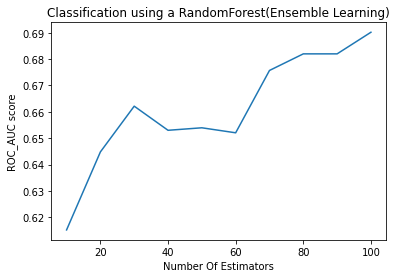

In [ ]:
estimators = []
roc_rf = []


for estimator in range(10, 101,10):
    model = RandomForestClassifier(n_estimators = estimator, random_state = 1)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    estimators.append(estimator)
    roc_rf.append(roc_auc_score(Y_test, Y_pred))


plt.plot(estimators,roc_rf)
plt.title('Classification using a RandomForest(Ensemble Learning)')
plt.xlabel('Number Of Estimators')
plt.ylabel('ROC_AUC score')
plt.show()

In [ ]:
ind = roc_rf.index(max(roc_rf)) 
print("Maximum ROC of Random Forest is for number of estimators = {}".format(estimators[ind]))

Maximum ROC of Random Forest is for number of estimators = 100


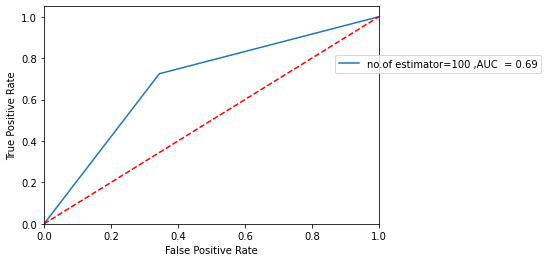

In [ ]:
auc_roc2=[]
fp2=[]
tp2=[]
estimator=100


model = RandomForestClassifier(n_estimators = estimator, random_state = 1)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, y_pred)
fp2.append(fpr)
tp2.append(tpr)
roc_auc = auc(fpr, tpr)
auc_roc2.append(roc_auc)

plt.figure()

for i in range(len(auc_roc2)):
    plt.plot(fp2[i], tp2[i], label = 'no.of estimator={} ,AUC  = {:.2f}'.format(estimator,auc_roc2[i]))
    
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor =(1.5,0.8), ncol = 3)
plt.show()

###  for number of estimators = 100

In [ ]:
model = RandomForestClassifier(n_estimators = 100, random_state = 1)
model.fit(X_train, Y_train)
Y_pred_rf = model.predict(X_test)

print("Accuracy of RandomForest model--> {:.2f}".format(accuracy_score(Y_test, Y_pred_rf)))

Accuracy of RandomForest model--> 0.69


# NN Classification

In [ ]:
from keras.models import Sequential
import keras.optimizers as opti
from keras.layers import Dense, Activation,Dropout


model = Sequential()
model.add(Dense(100, input_dim=11))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 100)               1200      
                                                                 
 activation_24 (Activation)  (None, 100)               0         
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_36 (Dense)            (None, 100)               10100     
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 activation_25 (Activation)  (None, 100)               0         
                                                                 
 dense_37 (Dense)            (None, 50)               

In [ ]:
X_train=X_train.astype('float64')
X_test=X_test.astype('float64')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=4, verbose=1, validation_split=0.2)

Epoch 1/10
78/78 [==============================] - 1s 5ms/step - loss: 1.4624 - accuracy: 0.5405 - val_loss: 5.4176 - val_accuracy: 0.4487
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 0.9916 - accuracy: 0.5534 - val_loss: 0.7421 - val_accuracy: 0.4744
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 1.1160 - accuracy: 0.5113 - val_loss: 0.6969 - val_accuracy: 0.5897
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 0.8992 - accuracy: 0.4693 - val_loss: 0.7701 - val_accuracy: 0.4744
Epoch 5/10
78/78 [==============================] - 0s 3ms/step - loss: 1.3809 - accuracy: 0.5081 - val_loss: 0.8284 - val_accuracy: 0.4615
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 0.9270 - accuracy: 0.5016 - val_loss: 0.7570 - val_accuracy: 0.4615
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 0.9779 - accuracy: 0.4919 - val_loss: 0.7454 - val_accuracy: 0.4487
Epoch 8/10
78/78 [==

In [ ]:
test_results = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test dataset - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')


5/5 [==============================] - 0s 2ms/step - loss: 0.7092 - accuracy: 0.5385
Test dataset - Loss: 0.709209680557251 - Accuracy: 53.84615659713745%


# Regression

## Support Vector Regressor (SVR)

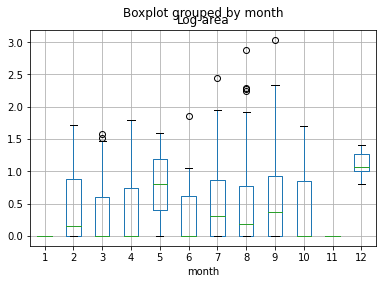

In [ ]:
dfAll['Log-area']=np.log10(dfAll['area']+1)
dfAll.boxplot(column='Log-area',by='month')

In [ ]:
def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)
    
X_data=dfAll.drop(['area','Log-area','month','day'],axis=1)
y_data=dfAll['Log-area']
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4)
y_train=y_train.values.reshape(y_train.size,1)

In [ ]:
param_grid = {'C': [0.001,0.01,0.1,1], 'epsilon': [10,1,0.1,0.01,0.001,0.0001], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid_SVR = GridSearchCV(SVR(),param_grid,refit=True,verbose=0,cv=5)
grid_SVR.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))
print("Best parameters obtained by Grid Search:",grid_SVR.best_params_)

Best parameters obtained by Grid Search: {'C': 0.1, 'epsilon': 1, 'kernel': 'sigmoid'}


In [ ]:
a=grid_SVR.predict(X_test)
print("RMSE for Support Vector Regression:",np.sqrt(np.mean((y_test-a)**2)))

RMSE for Support Vector Regression: 0.7996053729076765


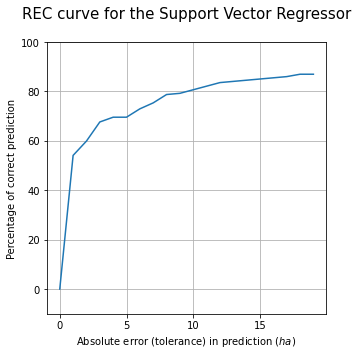

In [ ]:
rec_SVR=[]
for i in range(20):
    rec_SVR.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Support Vector Regressor\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(21)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(20),rec_SVR)

## Decision Tree Regressor


In [ ]:
tree_model = DecisionTreeRegressor(max_depth=10,criterion='mae')
tree_model.fit(scaler.fit_transform(X_train),scaler.fit_transform(y_train))
preds=tree_model.predict(X_test)
print("RMSE for Decision Tree:",np.sqrt(np.mean((y_test-preds)**2)))

RMSE for Decision Tree: 0.7127777535075381


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


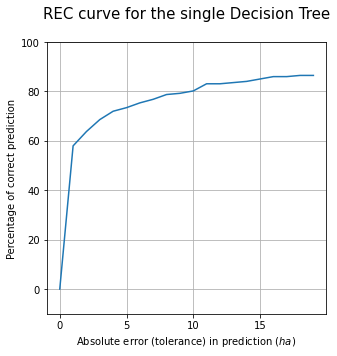

In [ ]:
rec_DT=[]
for i in range(20):
    rec_DT.append(rec(preds,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the single Decision Tree\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,21,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(20),rec_DT)

## Random Forest Regressor

In [ ]:
param_grid = {'max_depth': [2,5,10,15,20,50], 'max_leaf_nodes': [2,5,8,10], 'min_samples_leaf': [2,5,8,10],
             'min_samples_split':[2,5,8,10]}
grid_RF = GridSearchCV(RandomForestRegressor(),param_grid,refit=True,verbose=0,cv=5)
grid_RF.fit(X_train,y_train)
print("Best parameters obtained by Grid Search:",grid_RF.best_params_)

Best parameters obtained by Grid Search: {'max_depth': 10, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
preds=grid_RF.predict(X_test)
rmse_rf=np.sqrt(np.mean((y_test-preds)**2))
print("RMSE for Random Forest:",rmse_rf)

RMSE for Random Forest: 0.6566727569247165


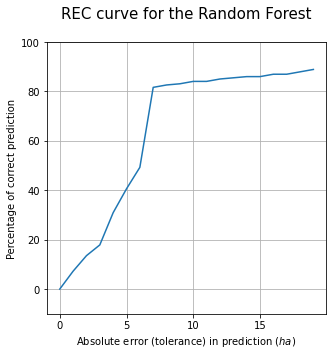

In [ ]:
rec_RF=[]
for i in range(20):
    rec_RF.append(rec(a,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Random Forest\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i for i in range(0,21,5)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(20),rec_RF)

## Comparison of relative performances

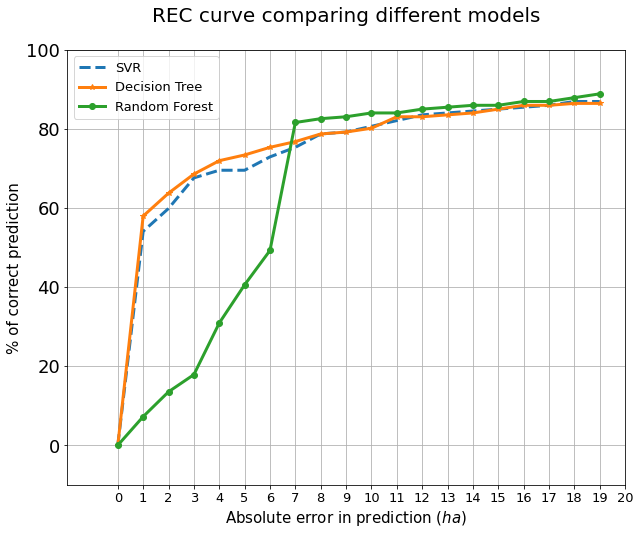

In [ ]:
plt.figure(figsize=(10,8))
plt.title("REC curve comparing different models\n",fontsize=20)
plt.xlabel("Absolute error in prediction ($ha$)",fontsize=15)
plt.ylabel("% of correct prediction",fontsize=15)
plt.xticks([i for i in range(0,21,1)],fontsize=13)
plt.ylim(-10,100)
plt.xlim(-2,20)
plt.yticks([i*20 for i in range(6)],fontsize=18)
plt.grid(True)
plt.plot(range(20),rec_SVR,'--',lw=3)
plt.plot(range(20),rec_DT,'*-',lw=3)
plt.plot(range(20),rec_RF,'o-',lw=3)
plt.legend(['SVR','Decision Tree','Random Forest'],fontsize=13)

# NN Models

In [ ]:
feat = dfAll
y = feat.pop('area')

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(feat), columns=feat.columns)
X = X.astype(float)
X

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,1.008313,0.569860,-1.968443,0.357721,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268
1,1.008313,-0.244001,1.110120,-1.090909,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268
2,1.008313,-0.244001,1.110120,0.840597,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268
3,1.440925,1.383722,-1.968443,0.357721,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155
4,1.440925,1.383722,-1.968443,1.323474,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268
...,...,...,...,...,...,...,...,...,...,...,...,...
512,-0.289524,-1.057862,0.230531,1.323474,-1.640083,-0.846648,0.474768,-1.563460,1.536084,-0.753800,-0.736124,-0.073268
513,-1.154748,-0.244001,0.230531,1.323474,-1.640083,-0.846648,0.474768,-1.563460,0.519019,1.638592,0.995798,-0.073268
514,1.008313,-0.244001,0.230531,1.323474,-1.640083,-0.846648,0.474768,-1.563460,0.398350,1.577248,1.498614,-0.073268
515,-1.587360,-0.244001,0.230531,0.840597,0.680957,0.549003,0.269382,0.500176,1.156839,-0.140366,-0.009834,-0.073268


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class customDataset:
  def __init__(self,features,target):
    self.features=features
    self.target=target

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    current_sample = self.features[idx,:]
    current_target = self.target[idx]
    return torch.tensor(current_sample,dtype=torch.float),torch.tensor(current_target,dtype=torch.float)
    


## Histogram of area burnt

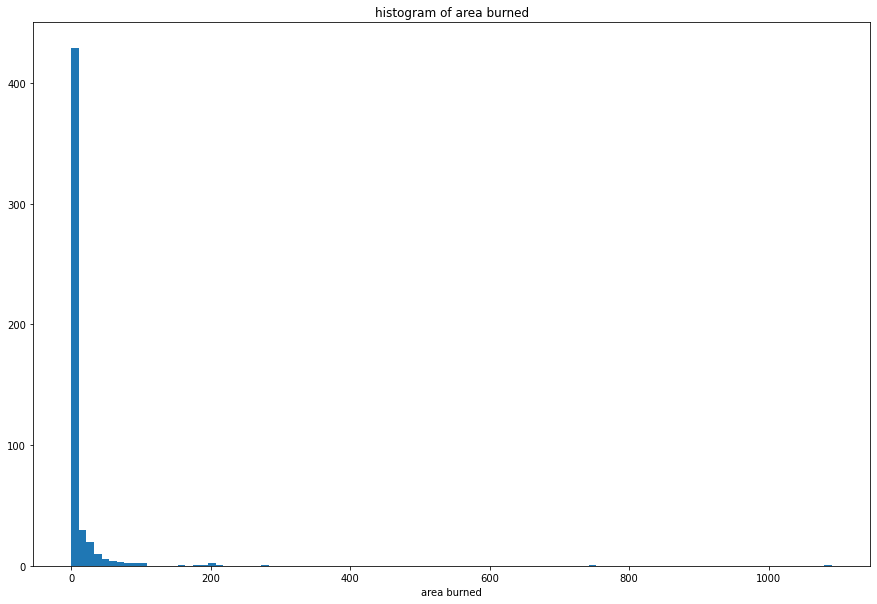

In [ ]:

plt.figure(figsize=(15,10))
plt.hist(y,bins=100)
plt.xlabel("area burned")
plt.title("histogram of area burned")
plt.show()




Here we can see from above histogram, target lable "area" is skewed so we have to use log-transformation to make it as normal so that the statistical analysis become more valid

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1)

y_train[y_train>=0]=np.log10(y_train+1)
y_test[y_test>=0]=np.log10(y_test+1)




train = customDataset(X_train.to_numpy(),y_train.to_numpy())
test = customDataset(X_test.to_numpy(),y_test.to_numpy())

train_loader = torch.utils.data.DataLoader(train,batch_size=10,num_workers=2)
test_loader = torch.utils.data.DataLoader(test,batch_size=10,num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MLP Regressor

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(12,64)
        #nn.init.uniform_(self.fc1.weight,a=0.0,b=1.0)
        self.fc2 = nn.Linear(64,32)
        #nn.init.uniform_(self.fc2.weight,a=0.0,b=1.0)
        self.fc3 = nn.Linear(32,1)
        #nn.init.uniform_(self.fc3.weight,a=0.0,b=1.0)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1 , 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

mlp = MLP().to(device)
criterian = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
print(mlp)


MLP(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
num_epochs = 100
best_train_loss = float('inf')

mlp.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      features, target = data
      target = target.reshape((target.shape[0], 1))
      features = features.to(device)
      target = target.to(device)
      outputs = mlp(features)
      loss = criterian(outputs, target)
      optimizer.zero_grad()
      loss.backward()
      running_loss += loss.item()
      optimizer.step()


    loss = running_loss / len(train_loader)
    print(f'Epoch:[{epoch+1}/{num_epochs}], Loss:{loss:.4f}')
    if best_train_loss > loss:
      best_train_loss = loss
      PATH = './mlp.pth'
      torch.save(mlp.state_dict(), PATH)
  
mlp.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
      running_loss=0.0
      features, target = data
      target = target.reshape((target.shape[0], 1))
      features = features.to(device)
      target = target.to(device)
      outputs = mlp(features)
      loss = criterian(outputs, target)
      optimizer.zero_grad()
      running_loss += loss.item()
      optimizer.step()
    

    loss = running_loss / len(test_loader)
    print(f'Loss of test dataset:{loss:.4f}')


Epoch:[1/100], Loss:0.5663
Epoch:[2/100], Loss:0.5089
Epoch:[3/100], Loss:0.4743
Epoch:[4/100], Loss:0.4544
Epoch:[5/100], Loss:0.4380
Epoch:[6/100], Loss:0.4066
Epoch:[7/100], Loss:0.4057
Epoch:[8/100], Loss:0.4063
Epoch:[9/100], Loss:0.3945
Epoch:[10/100], Loss:0.4002
Epoch:[11/100], Loss:0.3768
Epoch:[12/100], Loss:0.3837
Epoch:[13/100], Loss:0.3753
Epoch:[14/100], Loss:0.3867
Epoch:[15/100], Loss:0.3759
Epoch:[16/100], Loss:0.3639
Epoch:[17/100], Loss:0.3687
Epoch:[18/100], Loss:0.3675
Epoch:[19/100], Loss:0.3693
Epoch:[20/100], Loss:0.3635
Epoch:[21/100], Loss:0.3811
Epoch:[22/100], Loss:0.3722
Epoch:[23/100], Loss:0.3729
Epoch:[24/100], Loss:0.3607
Epoch:[25/100], Loss:0.3696
Epoch:[26/100], Loss:0.3634
Epoch:[27/100], Loss:0.3677
Epoch:[28/100], Loss:0.3605
Epoch:[29/100], Loss:0.3592
Epoch:[30/100], Loss:0.3525
Epoch:[31/100], Loss:0.3459
Epoch:[32/100], Loss:0.3653
Epoch:[33/100], Loss:0.3551
Epoch:[34/100], Loss:0.3460
Epoch:[35/100], Loss:0.3427
Epoch:[36/100], Loss:0.3555
E